# 日経平均株価 週足 メディアン統計

In [37]:
import sys
path_up = '..'
if not path_up in sys.path:
    sys.path.append(path_up)

In [53]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import yfinance as yf

from funcs.technical import calc_robust_bollinger

code = 'N225'
symbol = '^%s' % code
#symbol = 'USDJPY=X'
ticker = yf.Ticker(symbol)
df = ticker.history(period='3y', interval='1wk')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-03-28 00:00:00+09:00,27809.970703,28101.679688,27399.480469,27665.980469,145400000,0.0,0.0
2022-04-04 00:00:00+09:00,27685.650391,27965.939453,26764.359375,26985.800781,332500000,0.0,0.0
2022-04-11 00:00:00+09:00,26877.599609,27203.769531,26304.080078,27093.189453,333700000,0.0,0.0
2022-04-18 00:00:00+09:00,26831.449219,27580.640625,26571.380859,27105.259766,301900000,0.0,0.0
2022-04-25 00:00:00+09:00,26692.480469,26876.949219,26051.039062,26847.900391,311000000,0.0,0.0
...,...,...,...,...,...,...,...
2025-02-24 00:00:00+09:00,38359.671875,38485.949219,36840.121094,37155.500000,566900000,0.0,0.0
2025-03-03 00:00:00+09:00,37617.500000,37874.378906,36813.621094,36887.171875,659400000,0.0,0.0
2025-03-10 00:00:00+09:00,36972.589844,37326.269531,35987.128906,37053.101562,646200000,0.0,0.0


In [54]:
df0 = ticker.history(period='5y', interval='1wk')
df0

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-03-30 00:00:00+09:00,19181.900391,19336.189453,17646.500000,17820.189453,431300000,0.0,0.0
2020-04-06 00:00:00+09:00,17857.990234,19500.070312,17802.619141,19498.500000,489600000,0.0,0.0
2020-04-13 00:00:00+09:00,19312.039062,19922.070312,19014.320312,19897.259766,410800000,0.0,0.0
2020-04-20 00:00:00+09:00,19689.849609,19784.380859,18858.250000,19262.000000,378100000,0.0,0.0
2020-04-27 00:00:00+09:00,19410.839844,20365.890625,19410.179688,19619.349609,336200000,0.0,0.0
...,...,...,...,...,...,...,...
2025-02-24 00:00:00+09:00,38359.671875,38485.949219,36840.121094,37155.500000,566900000,0.0,0.0
2025-03-03 00:00:00+09:00,37617.500000,37874.378906,36813.621094,36887.171875,659400000,0.0,0.0
2025-03-10 00:00:00+09:00,36972.589844,37326.269531,35987.128906,37053.101562,646200000,0.0,0.0


## Moving Median

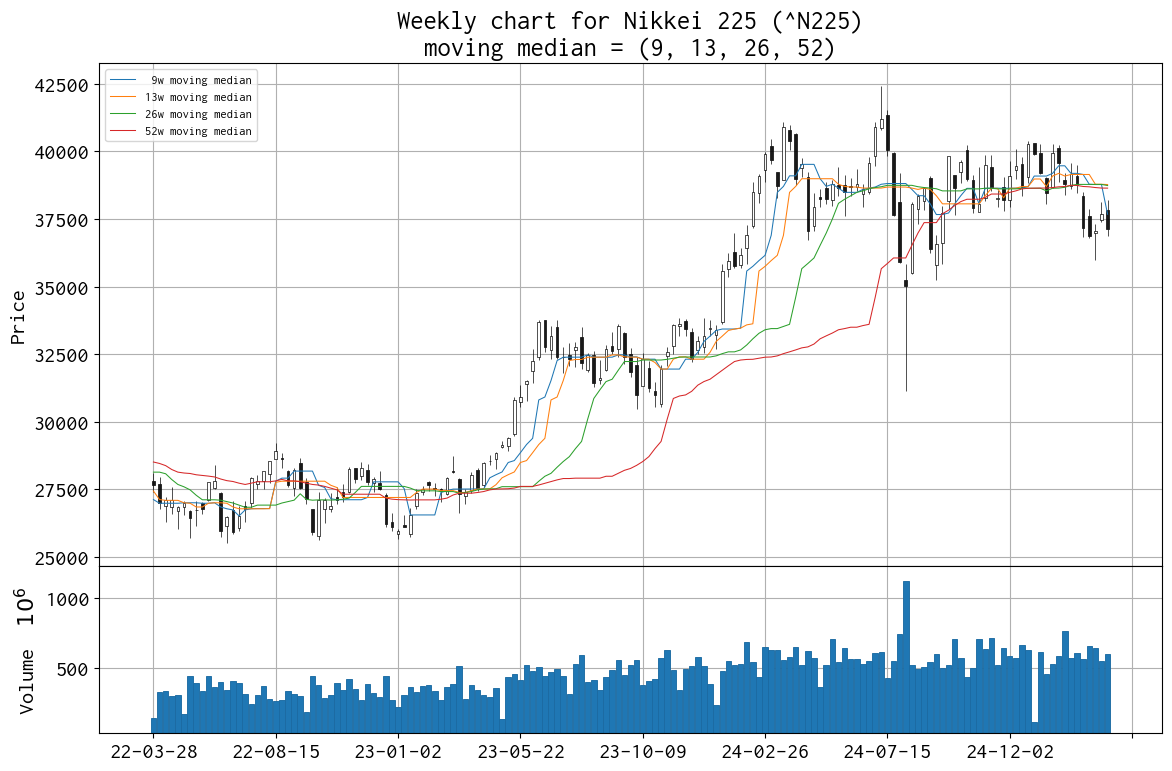

In [69]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize=(12, 8))
ax = dict()
n = 2
gs = fig.add_gridspec(
    n, 1,
    wspace=0.0, hspace=0.0,
    height_ratios=[3 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex='col')):
    ax[i] = axis
    ax[i].grid()

mm09 = df0['Close'].rolling(9).median()
mm13 = df0['Close'].rolling(13).median()
mm26 = df0['Close'].rolling(26).median()
mm52 = df0['Close'].rolling(52).median()

apds  = [
    mpf.make_addplot(mm09[df.index], width=0.75, label=' 9w moving median', ax=ax[0]),
    mpf.make_addplot(mm13[df.index], width=0.75, label='13w moving median', ax=ax[0]),
    mpf.make_addplot(mm26[df.index], width=0.75, label='26w moving median', ax=ax[0]),
    mpf.make_addplot(mm52[df.index], width=0.75, label='52w moving median', ax=ax[0]),
]   

mpf.plot(
    df, type='candle', style='default',
    volume=ax[1],
    datetime_format='%y-%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax[0],
)
ax[0].set_title('Weekly chart for %s (%s)\nmoving median = (9, 13, 26, 52)' %(ticker.info['longName'], symbol))
ax[0].legend(loc='upper left', fontsize=9)

plt.tight_layout()
plt.savefig('report_weekly_chart_median_%s.png' % code)
plt.show()

In [70]:
df.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-03-17 00:00:00+09:00,37453.828125,38128.578125,37377.550781,37677.058594,552400000,0.0,0.0
2025-03-24 00:00:00+09:00,37841.679688,38220.691406,36864.929688,37120.328125,599200000,0.0,0.0


In [71]:
df.tail(2)['Close']

Date
2025-03-17 00:00:00+09:00    37677.058594
2025-03-24 00:00:00+09:00    37120.328125
Name: Close, dtype: float64

In [72]:
df.tail(2)['Close'].diff()

Date
2025-03-17 00:00:00+09:00           NaN
2025-03-24 00:00:00+09:00   -556.730469
Name: Close, dtype: float64

In [73]:
df['Close'].tail(1) - df['Open'].tail(1)

Date
2025-03-24 00:00:00+09:00   -721.351562
dtype: float64

In [74]:
df['Close'].rolling(9).median().tail(10)

Date
2025-01-20 00:00:00+09:00    39190.398438
2025-01-27 00:00:00+09:00    39470.441406
2025-02-03 00:00:00+09:00    39470.441406
2025-02-10 00:00:00+09:00    39190.398438
2025-02-17 00:00:00+09:00    39190.398438
2025-02-24 00:00:00+09:00    39149.429688
2025-03-03 00:00:00+09:00    38787.019531
2025-03-10 00:00:00+09:00    38776.941406
2025-03-17 00:00:00+09:00    38776.941406
2025-03-24 00:00:00+09:00    37677.058594
Name: Close, dtype: float64

In [75]:
df['Close'].rolling(13).median().tail(10)

Date
2025-01-20 00:00:00+09:00    39091.171875
2025-01-27 00:00:00+09:00    39190.398438
2025-02-03 00:00:00+09:00    39091.171875
2025-02-10 00:00:00+09:00    39149.429688
2025-02-17 00:00:00+09:00    39149.429688
2025-02-24 00:00:00+09:00    39149.429688
2025-03-03 00:00:00+09:00    39149.429688
2025-03-10 00:00:00+09:00    38787.019531
2025-03-17 00:00:00+09:00    38787.019531
2025-03-24 00:00:00+09:00    38776.941406
Name: Close, dtype: float64

In [76]:
df['Close'].rolling(26).median().tail(10)

Date
2025-01-20 00:00:00+09:00    38639.265625
2025-01-27 00:00:00+09:00    38645.330078
2025-02-03 00:00:00+09:00    38674.824219
2025-02-10 00:00:00+09:00    38744.458984
2025-02-17 00:00:00+09:00    38781.980469
2025-02-24 00:00:00+09:00    38781.980469
2025-03-03 00:00:00+09:00    38781.980469
2025-03-10 00:00:00+09:00    38781.980469
2025-03-17 00:00:00+09:00    38781.980469
2025-03-24 00:00:00+09:00    38739.419922
Name: Close, dtype: float64

In [77]:
df['Close'].rolling(52).median().tail(10)

Date
2025-01-20 00:00:00+09:00    38665.839844
2025-01-27 00:00:00+09:00    38692.914062
2025-02-03 00:00:00+09:00    38704.769531
2025-02-10 00:00:00+09:00    38747.330078
2025-02-17 00:00:00+09:00    38742.291016
2025-02-24 00:00:00+09:00    38704.769531
2025-03-03 00:00:00+09:00    38692.914062
2025-03-10 00:00:00+09:00    38665.839844
2025-03-17 00:00:00+09:00    38646.929688
2025-03-24 00:00:00+09:00    38644.509766
Name: Close, dtype: float64

## Robust Bollinger bands

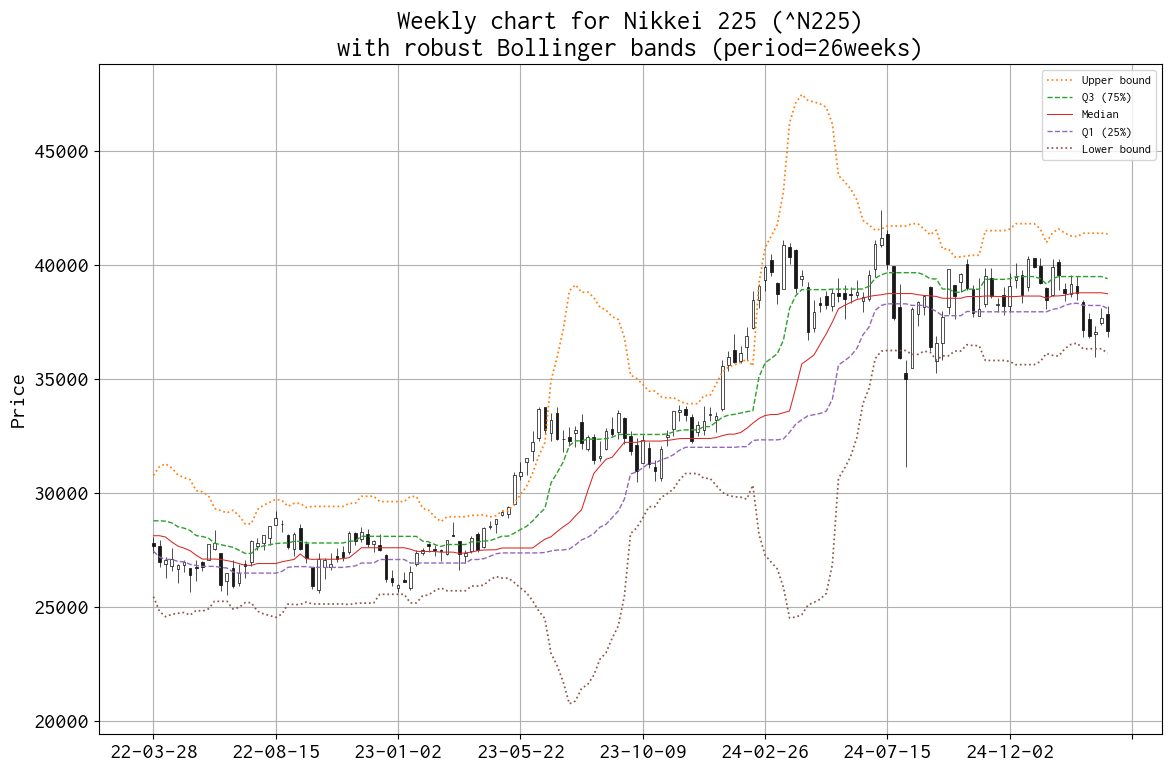

In [78]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 8))

# Bollinger bands
period = 26
mv_median = df0['Close'].rolling(period).median()
mv_q1 = df0['Close'].rolling(period).quantile(.25)
mv_q3 = df0['Close'].rolling(period).quantile(.75)
mv_iqr = mv_q3 - mv_q1
mv_lower = mv_q1 - mv_iqr * 1.5
mv_upper = mv_q3 + mv_iqr * 1.5

apds  = [
    mpf.make_addplot(mv_upper[df.index], width=1.25, color='C1', linestyle='dotted', label='Upper bound', ax=ax),
    mpf.make_addplot(mv_q3[df.index], width=1, color='C2', linestyle='dashed', label='Q3 (75%)', ax=ax),
    mpf.make_addplot(mv_median[df.index], width=0.75, color='C3', label='Median', ax=ax),
    mpf.make_addplot(mv_q1[df.index], width=1, color='C4', linestyle='dashed', label='Q1 (25%)', ax=ax),
    mpf.make_addplot(mv_lower[df.index], width=1.25, color='C5', linestyle='dotted', label='Lower bound', ax=ax),
]

fb_half = dict(y1=mv_q1.values,y2=mv_q3.values, where=mv_q1<mv_q3, color='red', alpha=0.6, interpolate=True, ax=ax)

mpf.plot(
    df, type='candle', style='default',
    addplot=apds,
    datetime_format='%y-%m-%d',
    xrotation=0,
    ax=ax,
)

ax.grid()
ax.legend(loc='best', fontsize=9)

try:
    ax.set_title('Weekly chart for %s (%s)\nwith robust Bollinger bands (period=%dweeks)' % (ticker.info['longName'], symbol, period))
except KeyError:
    ax.set_title('Weekly chart for %s\nwith robust Bollinger bands (period=%sweeks)' % (symbol, period))

plt.tight_layout()
plt.savefig('report_weekly_chart_bollinger_robust_%s.png' % code)
plt.show()

## ヒストグラムと Q-Q プロット

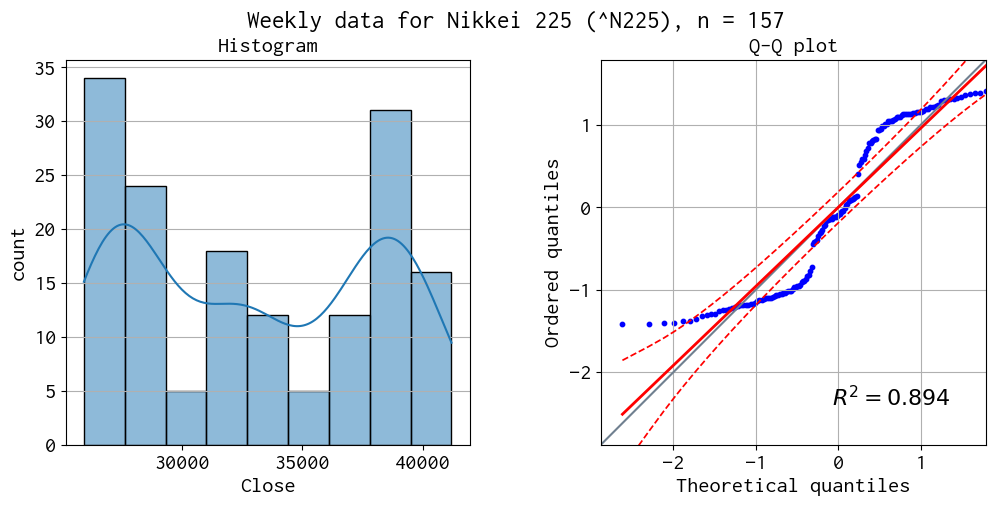

In [80]:
plt.rcParams['font.size'] = 16
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(
    df['Close'],
    kde=True,
    ax=axes[0]
)

# ヒストグラム
axes[0].set_xlabel("Close")
axes[0].set_ylabel("count")
axes[0].grid(axis = 'y')
axes[0].set_title('Histogram', fontsize=16)

# Q-Q プロット
pg.qqplot(df['Close'], s=10,  ax=axes[1])
axes[1].set_title('Q-Q plot', fontsize=16)
axes[1].grid()

plt.suptitle('Weekly data for %s (%s), n = %d' % (ticker.info['longName'], symbol, len(df)), fontsize=18)
plt.subplots_adjust(wspace=0.3)
plt.savefig('report_weekly_histogram_qqplot_%s.png' % code)
plt.show()